In [1]:
import numpy as np
import pandas as pd
from money_parser import price_dec
import censusgeocode as cg

pd.options.display.max_columns = None

In [75]:
def curr_to_float(v): return float(price_dec(v)) if v else v
def tf_to_10(v): return 1 if v == 't' else 0
def nulls_to_0(v): return float(0 if (pd.isnull(v) or v == '') else v)

converters_to_columns = [
    (curr_to_float, ['price', 'weekly_price', 'monthly_price']),
    (tf_to_10, ['instant_bookable', 'host_is_superhost']),
    (nulls_to_0, ['bedrooms', 'bathrooms'])
]

converters = {col: conv for conv, cols in converters_to_columns for col in cols}

df = pd.read_csv('data/listings.csv', index_col='id', converters=converters)

In [76]:
df[b]

,host_is_superhost,neighbourhood,accommodates,bed_type,bathrooms,bedrooms,room_type,property_type,amenities,number_of_reviews,price
id,,,,,,,,,,,
3647,0,Harlem,2,Pull-out Sofa,1.0,1.0,Private room,Apartment,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",0,150.0
3831,0,Brooklyn,3,Real Bed,1.0,1.0,Entire home/apt,Guest suite,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",279,89.0
5022,0,East Harlem,1,Real Bed,1.0,0.0,Entire home/apt,Apartment,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",9,80.0
5099,0,Midtown East,2,Real Bed,1.0,1.0,Entire home/apt,Apartment,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",75,200.0
5121,0,Bedford-Stuyvesant,2,Futon,0.0,1.0,Private room,Apartment,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",49,60.0
...,...,...,...,...,...,...,...,...,...,...,...
38564068,0,Bedford-Stuyvesant,7,Real Bed,2.0,3.0,Entire home/apt,Apartment,"{Wifi,Kitchen,""Smoke detector"",""Carbon monoxid...",0,199.0
38564524,0,Manhattan,2,Real Bed,1.0,0.0,Entire home/apt,Apartment,"{TV,Wifi,""Air conditioning"",Elevator,Heating,W...",0,175.0
38566777,0,Brooklyn,1,Real Bed,1.0,1.0,Private room,Apartment,"{Wifi,""Air conditioning"",Kitchen,Gym,Elevator,...",0,35.0


In [48]:
df.columns[df.columns.str.contains('price')]

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')

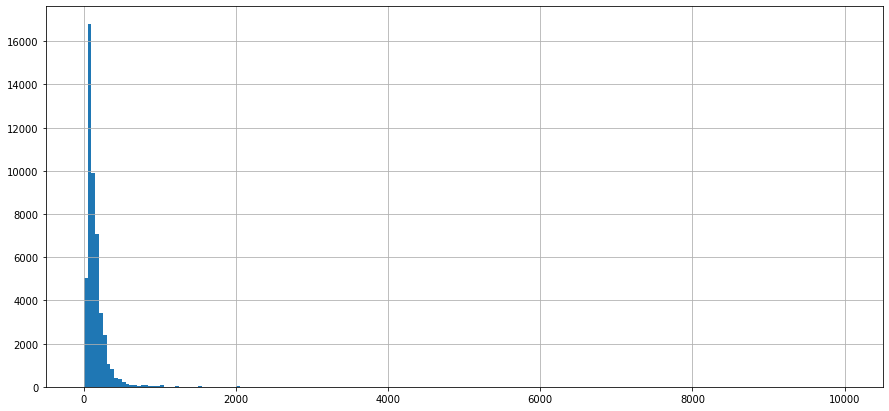

In [43]:
df['price'].map(lambda v: float(price_dec(v))).hist(bins=200, figsize=(15, 7));

In [73]:
import openapi_client
from openapi_client.rest import ApiException

def bunch(iterable, n=100):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

unique_host_names = df['host_name'].unique().tolist()
unique_host_names_dict = dict(zip(range(len(unique_host_names)), unique_host_names))
unique_host_names_rev_dict = {v: k for k, v in unique_host_names_dict.items()}

personalNameGeoIn = [{
    'id': unique_host_names_rev_dict[name],
    'name': name,
    'countryIso2': 'US'
} for name in unique_host_names]
        
personalNameGeoIn_batch_gen = bunch(personalNameGeoIn)

responses = []

configuration = openapi_client.Configuration()
configuration.api_key['X-API-KEY'] = 'beb2d6cd9009230057a169d123476090'

api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))

for batch in personalNameGeoIn_batch_gen:
    batch_personal_name_geo_in = openapi_client.BatchPersonalNameGeoIn(batch) # BatchPersonalNameGeoIn | A list of personal names, with a country ISO2 code (optional)

    try:
        api_response = api_instance.gender_full_geo_batch(batch_personal_name_geo_in=batch_personal_name_geo_in)
        responses.append(api_response)
    except ApiException as e:
        print("Exception when calling PersonalApi->gender_full_geo_batch: %s\n" % e)

In [4]:
crimes_df = pd.read_csv('data/NYC_crime.csv')
census_df = pd.read_csv('data/nyc_census_tracts.csv')
census_blocks_df = pd.read_csv('data/census_block_loc.csv')

In [5]:
census_df.sample(10)

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
1505,36081015400,Queens,Queens,2524,1257,1267,25.1,2.4,13.2,0.0,28.4,1461,53095.0,12530.0,20350.0,3860.0,18.1,33.9,16.2,27.3,31.0,12.9,12.7,35.8,9.9,39.7,10.7,1.5,2.5,42.3,1273,81.0,8.2,10.3,0.5,8.9
1797,36081061301,Queens,Queens,6281,3022,3259,33.8,56.1,0.9,0.0,8.0,3729,52153.0,27661.0,23785.0,3234.0,20.5,34.4,27.9,25.9,19.7,15.2,11.4,16.3,9.3,68.3,3.5,2.0,0.6,40.0,2827,80.7,10.0,9.3,0.0,8.4
506,36047021300,Kings,Brooklyn,4296,1982,2314,5.6,19.2,70.8,0.0,1.5,2940,38750.0,6123.0,25640.0,3275.0,24.8,37.3,41.7,28.6,19.7,3.3,6.7,7.8,2.7,67.8,8.6,2.4,10.7,42.5,1966,71.8,21.4,6.8,0.0,20.6
1953,36081099802,Queens,Queens,5391,2244,3147,13.5,18.5,64.7,0.0,2.4,3599,34287.0,7875.0,24765.0,4683.0,21.4,13.8,40.2,20.0,19.4,12.5,7.9,38.5,10.2,38.5,4.7,0.7,7.4,47.7,2384,67.7,26.6,5.7,0.0,10.6
222,36005031000,Bronx,Bronx,4869,2181,2688,24.9,43.6,17.3,0.0,11.4,3865,80724.0,14256.0,28097.0,4294.0,11.0,23.6,42.0,16.6,22.3,11.0,8.1,54.2,14.5,24.2,2.4,1.3,3.4,33.8,1833,76.1,21.7,2.2,0.0,7.1
755,36047049200,Kings,Brooklyn,3637,1974,1663,15.5,44.7,14.0,0.4,24.7,1986,46146.0,6929.0,18859.0,3650.0,31.5,49.5,37.6,16.3,17.8,12.0,16.4,19.1,7.2,50.0,3.5,7.6,12.5,39.0,1302,78.0,9.4,12.7,0.0,10.5
825,36047056500,Kings,Brooklyn,3125,1557,1568,10.9,78.4,0.4,0.0,3.8,2381,78445.0,14560.0,48718.0,6419.0,9.9,0.0,73.9,6.0,13.0,4.4,2.7,12.4,0.9,69.2,7.8,6.0,3.7,35.3,1935,85.2,7.5,7.2,0.0,7.7
514,36047022100,Kings,Brooklyn,4255,2206,2049,16.9,28.9,48.8,1.6,3.1,3234,37140.0,12288.0,28698.0,4746.0,26.3,12.7,44.6,21.3,21.8,2.8,9.5,7.7,1.3,75.2,4.3,8.6,3.0,43.0,2333,77.9,15.2,6.9,0.0,12.4
680,36047040300,Kings,Brooklyn,3724,1604,2120,31.6,6.9,60.6,0.0,0.9,2307,27827.0,5244.0,16171.0,3637.0,41.8,70.4,37.9,22.9,21.6,7.8,9.7,18.4,0.0,66.6,8.6,0.0,6.4,47.5,1266,78.7,15.7,5.6,0.0,20.5
1695,36081047000,Queens,Queens,3322,1741,1581,21.1,3.4,9.5,11.3,39.4,2094,53409.0,9751.0,17247.0,2432.0,10.9,17.0,17.9,39.0,16.8,9.5,16.9,34.7,4.7,57.3,2.6,0.0,0.8,51.1,1299,86.8,8.5,4.6,0.0,15.8


In [7]:
census_blocks_df['CensusTract'] = census_blocks_df['BlockCode'].apply(lambda v: int(str(v)[:-4]))

In [8]:
tract_to_coords_df = census_blocks_df.drop('BlockCode', axis='columns').groupby('CensusTract').mean()

In [9]:
census_all_df = tract_to_coords_df.reset_index().merge(census_df, on='CensusTract', how='right')

In [10]:
census_all_df = census_all_df[census_all_df['Latitude'].notnull()]

In [11]:
census_all_df.groupby('Borough')[['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']].mean()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr
Borough,,,,
Bronx,39504.879630,8574.972222,19537.003021,3487.350453
Brooklyn,54352.684140,11944.056452,27920.572386,4726.540214
Manhattan,83593.674074,18303.551852,69661.963768,12786.134058
Queens,62359.248050,13200.783151,27581.537984,4339.313178
Staten Island,72021.233645,13995.672897,32022.444444,4526.250000


In [12]:
census_all_df.groupby('County')[['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']].mean()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr
County,,,,
Bronx,39504.879630,8574.972222,19537.003021,3487.350453
Kings,54352.684140,11944.056452,27920.572386,4726.540214
New York,83593.674074,18303.551852,69661.963768,12786.134058
Queens,62359.248050,13200.783151,27581.537984,4339.313178
Richmond,72021.233645,13995.672897,32022.444444,4526.250000


In [13]:
crimes_df.sample(10)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
32,916084988,20,MANHATTAN,06/04/2016,17:50:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,321,"LARCENY,PETIT FROM AUTO",RESIDENCE - APT. HOUSE,07/22/2019,NaN,NaN,NaN,NaN,NaN
30,192960911,26,MANHATTAN,06/01/2016,12:00:00,07/07/2019,21:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,578,VIOLATION,INSIDE,HARRASSMENT 2,NaN,638,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,07/19/2019,NaN,NaN,NaN,NaN,NaN
43,302430675,25,MANHATTAN,08/18/2016,08:00:00,08/18/2016,20:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,113,FELONY,INSIDE,FORGERY,NaN,723,"FORGERY,DRIVERS LICENSE",PUBLIC BUILDING,08/30/2019,NaN,NaN,NaN,NaN,NaN
28,162814945,34,MANHATTAN,05/27/2016,12:00:00,02/14/2017,12:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,113,FELONY,INSIDE,FORGERY,NaN,729,"FORGERY,ETC.,UNCLASSIFIED-FELO",RESIDENCE - APT. HOUSE,04/02/2019,NaN,NaN,NaN,NaN,NaN
0,403250906,26,MANHATTAN,01/01/2016,00:01:00,12/31/2017,23:59:00,COMPLETED,GRANT,N.Y. HOUSING POLICE,233,MISDEMEANOR,INSIDE,SEX CRIMES,NaN,175,"SEXUAL ABUSE 3,2",RESIDENCE - PUBLIC HOUSING,01/02/2019,NaN,NaN,NaN,NaN,NaN
20,974105176,10,MANHATTAN,04/01/2016,08:00:00,09/06/2019,08:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,109,FELONY,NaN,GRAND LARCENY,NaN,407,"LARCENY,GRAND BY DISHONEST EMP",SMALL MERCHANT,09/24/2019,NaN,NaN,NaN,NaN,NaN
59,625425537,26,MANHATTAN,10/29/2016,04:55:00,10/29/2016,04:55:00,COMPLETED,NaN,N.Y. POLICE DEPT,112,FELONY,NaN,THEFT-FRAUD,NaN,739,"FRAUD,UNCLASSIFIED-FELONY",STREET,09/27/2019,NaN,NaN,NaN,NaN,NaN
57,266120857,32,MANHATTAN,10/20/2016,23:00:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,233,MISDEMEANOR,INSIDE,SEX CRIMES,NaN,175,"SEXUAL ABUSE 3,2",RESIDENCE - APT. HOUSE,03/01/2019,NaN,NaN,NaN,NaN,NaN
27,250595754,5,MANHATTAN,05/26/2016,00:00:00,02/27/2019,23:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,109,FELONY,INSIDE,GRAND LARCENY,NaN,426,"LARCENY,GRAND BY BANK ACCT COMPROMISE-TELLER",BANK,05/09/2019,NaN,NaN,NaN,NaN,NaN
63,407241454,28,MANHATTAN,12/08/2016,19:00:00,12/08/2016,22:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,104,FELONY,INSIDE,RAPE,NaN,153,RAPE 3,RESIDENCE - APT. HOUSE,03/06/2019,NaN,NaN,NaN,NaN,NaN


In [14]:
crimes_df['ADDR_PCT_CD'].unique()

array([26,  6, 23, 18, 14, 25, 34,  5, 28, 30, 32, 33, 10, 19,  9,  1, 24,
       20,  7])

In [15]:
listings = pd.read_csv('data/listings.csv')

/home/abhivik/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,$150.00,NaN,NaN,$200.00,$75.00,2,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
1,3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,Brooklyn,Brooklyn,NY,11238,New York,"Brooklyn, NY",US,United States,40.68514,-73.95976,t,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,W

In [44]:
listings[listings['id'] == 33372668]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
40130,33372668,https://www.airbnb.com/rooms/33372668,20190912153101,2019-09-13,"Charming Cozy Apartment, Bushwick Brooklyn",Charming studio apartment with beautiful skyli...,"600 sq ft, 1 room. *1 full-sized bed, sleeps ...",Charming studio apartment with beautiful skyli...,none,"Prime location in artsy Bushwick, Brooklyn. Va...",***Please note landlord may be showing apartme...,Everything needed in short walking distance in...,NaN,"I will be abroad, please reach out for any needs.",Please keep home as similar as to how you foun...,NaN,NaN,https://a0.muscache.com/im/pictures/7f615bb5-8...,NaN,15488551,https://www.airbnb.com/users/show/15488551,Vanieta,2014-05-13,"Brooklyn, New York, United States",Work in hospitality management.,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/d10c7...,https://a0.muscache.com/im/pictures/user/d10c7...,Williamsburg,1.0,1.0,"['email', 'phone']",t,f,"Brooklyn, NY, United States",Brooklyn,Williamsburg,Brooklyn,Brooklyn,NY,11206,New York,"Brooklyn, NY",US,United States,40.7045,-73.94357,t,Apartment,Entire home/apt,4,1.0,0.0,2.0,Real Bed,"{TV,""Air conditioning"",Kitchen,""Free street pa...",NaN,$109.00,NaN,NaN,$400.00,$70.00,1,$0.00,5,24,5,5,24,24,5.0,24.0,yesterday,t,5,5,5,5,2019-09-13,7,7,2019-05-02,2019-08-24,86.0,9.0,9.0,10.0,9.0,10.0,9.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.56


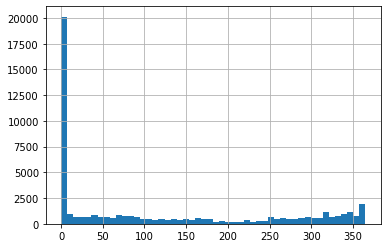

In [56]:
listings['availability_365'].hist(bins=50)

In [27]:
pd.DataFrame(df.loc[33372668])

,33372668
name,"Charming Cozy Apartment, Bushwick Brooklyn"
host_id,15488551
host_name,Vanieta
neighbourhood_group,Brooklyn
neighbourhood,Williamsburg
latitude,40.7045
longitude,-73.9436
room_type,Entire home/apt
price,150
minimum_nights,6
